We import the necesarry libraries
pandas and numpy: For handling data structures and numerical operations.

matplotlib.pyplot and seaborn: For data visualization.

statsmodels.tsa.stattools.adfuller: To perform the Augmented Dickey-Fuller (ADF) test, which checks if the time series is stationary.

statsmodels.graphics.tsaplots.plot_acf, plot_pacf: To plot the Autocorrelation (ACF) and Partial Autocorrelation (PACF) functions, helping to determine SARIMA parameters.

statsmodels.tsa.seasonal.seasonal_decompose: To decompose the time series into trend, seasonality, and residual components.

statsmodels.tsa.statespace.sarimax.SARIMAX: The SARIMA model implementation used for forecasting.

sklearn.metrics: Provides Mean Absolute Error (MAE) and Mean Squared Error (MSE) for evaluating model performance.

warnings: To suppress unnecessary warning messages during model training.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

Loading the dataset

In [ ]:
data=pd.read_csv('/content/Mobile Payments.csv',index_col=[0], parse_dates=[0]) # We set the index column and know its dates
print("Dataset Loaded:")
print(data.head())

Dataset Loaded:
             Month  Active Agents  \
Year                                
2023-01-01  August         333428   
2023-01-01    July         330912   
2023-01-01    June         328543   
2023-01-01     May         334726   
2023-01-01   April         329968   

            Total Registered Mobile Money Accounts (Millions)  \
Year                                                            
2023-01-01                                              77.55   
2023-01-01                                              77.21   
2023-01-01                                              76.99   
2023-01-01                                              77.34   
2023-01-01                                              75.96   

            Total Agent Cash in Cash Out (Volume Million)  \
Year                                                        
2023-01-01                                         208.61   
2023-01-01                                         202.85   
2023-01-01              

First I will perform a preliminary analysis to understand the structure and types of data columns

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 198 entries, 2023-01-01 to 2007-01-01
Data columns (total 5 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Month                                              198 non-null    object 
 1   Active Agents                                      198 non-null    int64  
 2   Total Registered Mobile Money Accounts (Millions)  198 non-null    float64
 3   Total Agent Cash in Cash Out (Volume Million)      198 non-null    float64
 4   Total Agent Cash in Cash Out (Value KSh billions)  198 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 9.3+ KB
None


Converting my dates to Datetime

Handling Missing Values

In [ ]:
print("Missing values detected. Replacing with mean...")
    # Check for Missing Values & Replace with Mean
if data.isnull().sum().any():
    data.fillna(data.mean(), inplace=True)

Missing values detected. Replacing with mean...


In [ ]:
# Summary statistics (mean, median, std, etc.)
summary_stats = data.describe()

# Import the stats module
from scipy import stats

# Perform t-test (Example: Comparing transaction volume with a mean value)
t_stat, p_value = stats.ttest_1samp(data['Total Agent Cash in Cash Out (Volume Million)'], data['Total Agent Cash in Cash Out (Volume Million)'].mean())

# Print results
print("Summary Statistics:\n", summary_stats)
print("\nT-Test Results:")
print("T-Statistic:", t_stat)
print("P-Value:", p_value)

Summary Statistics:
        Active Agents  Total Registered Mobile Money Accounts (Millions)  \
count     198.000000                                         198.000000   
mean   141792.828283                                          33.341681   
std    104703.538988                                          22.899713   
min       307.000000                                           0.020992   
25%     38726.000000                                          17.798950   
50%    130748.000000                                          26.483650   
75%    223003.000000                                          53.464200   
max    334726.000000                                          77.550000   

       Total Agent Cash in Cash Out (Volume Million)  \
count                                     198.000000   
mean                                       94.448061   
std                                        64.829920   
min                                         0.021714   
25%                    

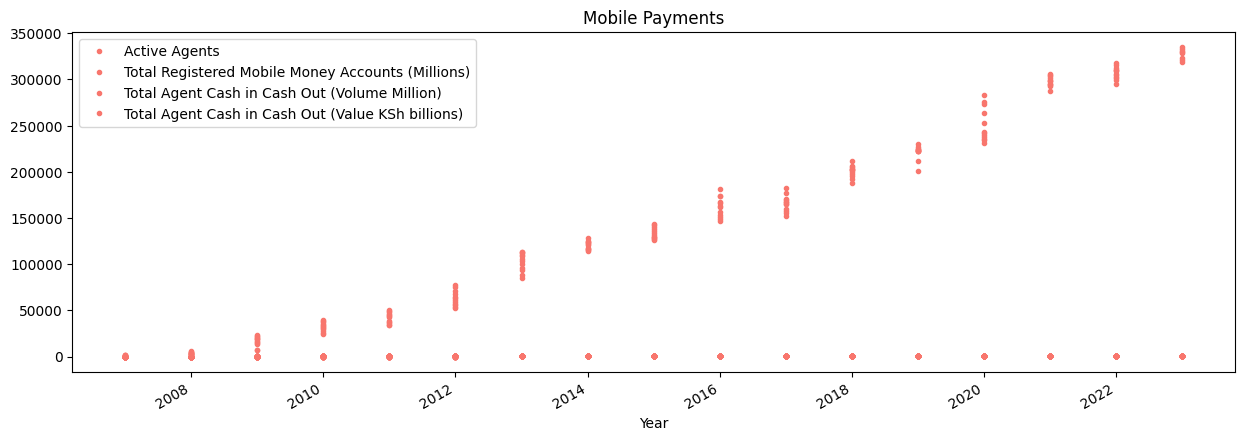

In [ ]:
# Color pallete for plotting
color_pl=["#F8766D","#D39200","#93AA00","#00BA38","#00C19F","#00B9E3","#619CFF","#DB72FB"]

data.plot(style='.',figsize=(15,5),color=color_pl[0],title='Mobile Payments')
plt.show()

Exploratory Data Analysis
This step involves visualizing the trend in mobile money transactions over time.
Analysis
This plot helps identify trends, seasonality, and fluctuations in mobile money transactions.

If the plot shows an upward trend, transactions are increasing over time.

Repeating patterns suggest seasonality.

This visualization is crucial before applying SARIMA, as it helps determine whether differencing or seasonal adjustments are needed.

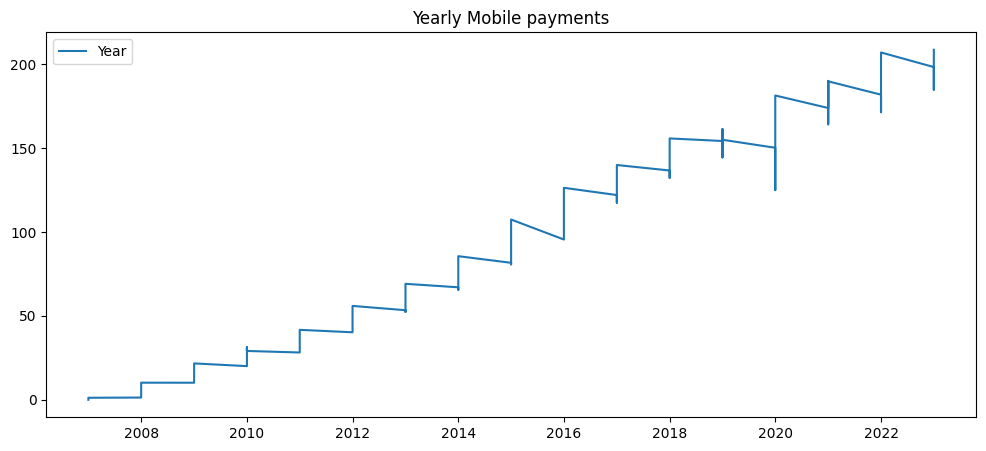

In [ ]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Total Agent Cash in Cash Out (Volume Million)'], label='Year')
plt.legend()
plt.title('Yearly Mobile payments')
plt.show()

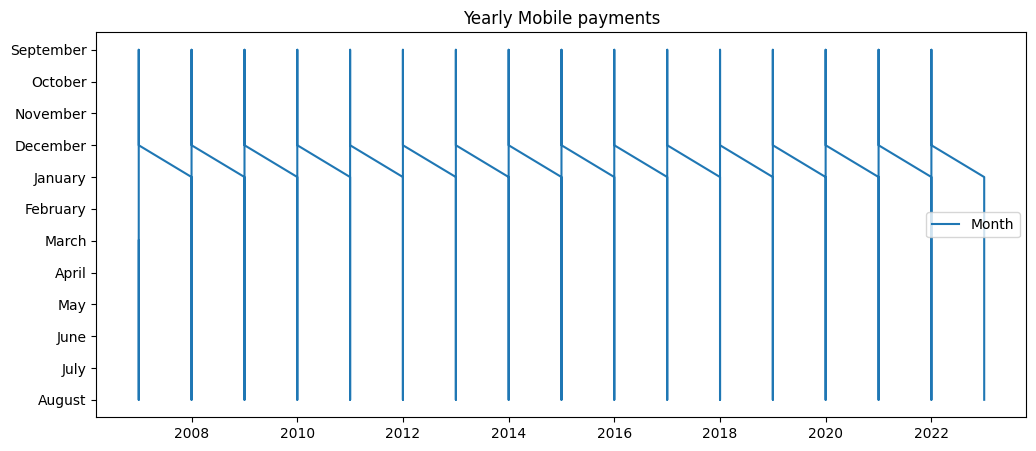

In [ ]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Month'], label='Month')
plt.legend()
plt.title('Yearly Mobile payments')
plt.show()

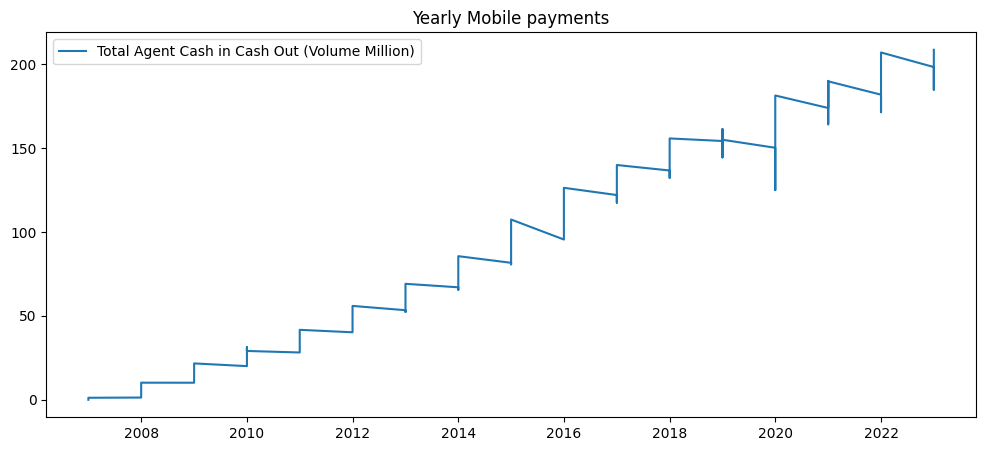

In [ ]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Total Agent Cash in Cash Out (Volume Million)'], label='Total Agent Cash in Cash Out (Volume Million)')
plt.legend()
plt.title('Yearly Mobile payments')
plt.show()

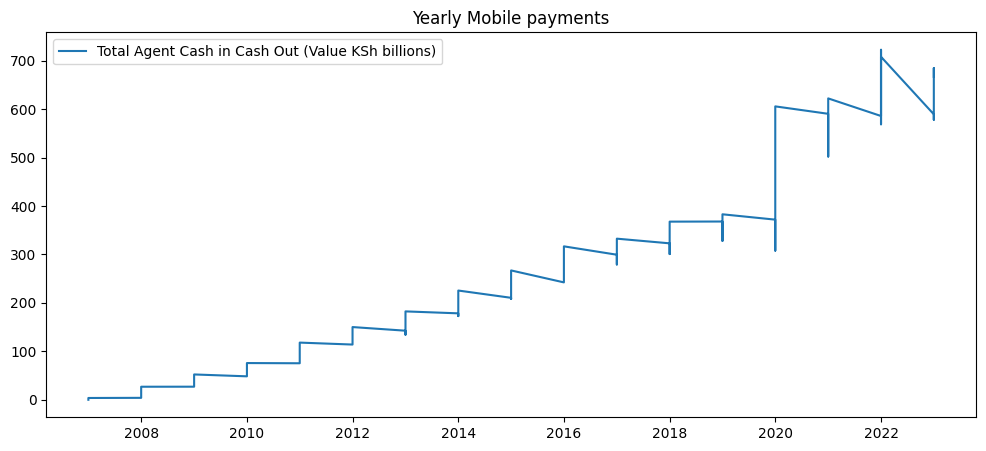

In [ ]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Total Agent Cash in Cash Out (Value KSh billions)'], label='Total Agent Cash in Cash Out (Value KSh billions)')
plt.legend()
plt.title('Yearly Mobile payments')
plt.show()

In [ ]:
Time series decomposition helps break down the data into its fundamental components: trend, seasonality, and residuals (random noise).
Analysis
Trend: Indicates whether transactions are increasing, decreasing, or stable over time.

Seasonality: Highlights repeating patterns (e.g., high transactions in festive months).

Residuals: Helps determine if additional modeling is needed.

This decomposition guides SARIMA parameter selection—if the residuals still show patterns, more differencing or adjustments may be needed

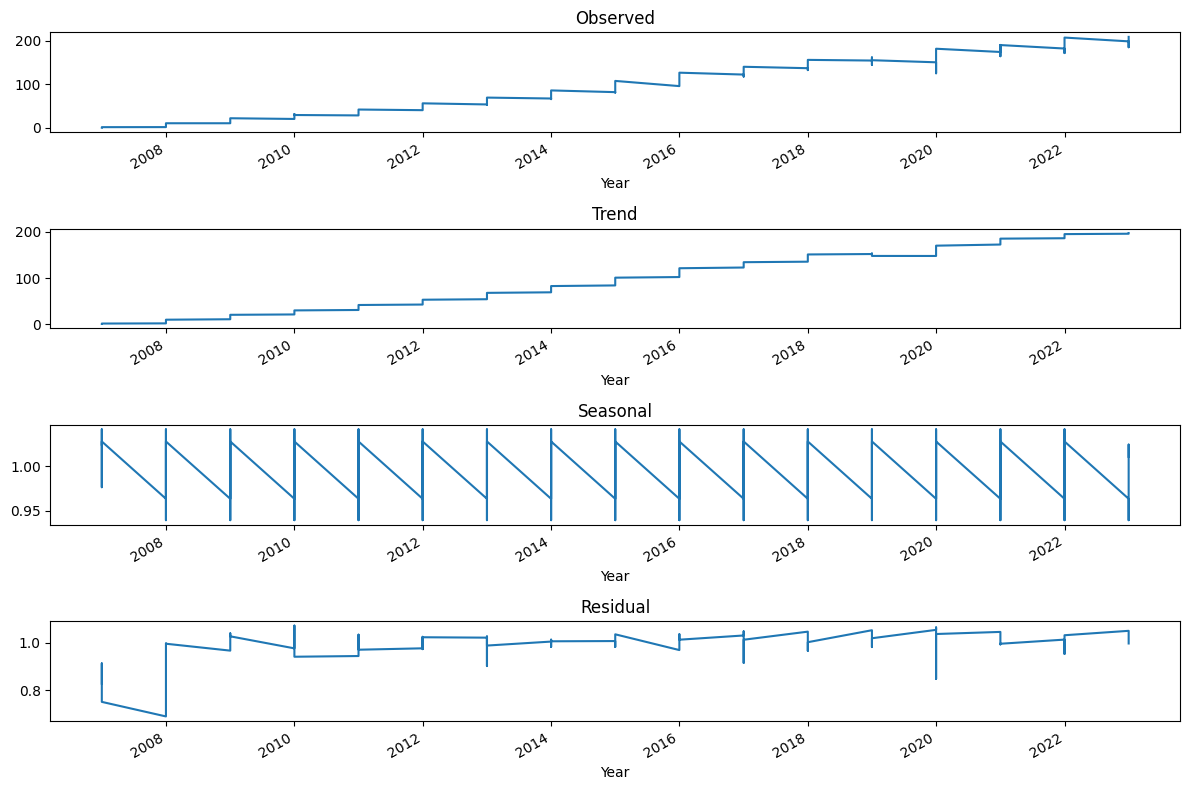

In [ ]:
# Time Series Decomposition
decomposition = seasonal_decompose(x=data['Total Agent Cash in Cash Out (Volume Million)'], model='multiplicative', period=12) # Access the column from your dataframe
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

Why Check for Stationarity?
SARIMA assumes that the time series is stationary—meaning its statistical properties (mean, variance, and autocorrelation) remain constant over time.
Define the check_stationarity() function:

Uses the Augmented Dickey-Fuller (ADF) test (adfuller()) to assess stationarity.

timeseries.dropna(): Ensures missing values do not affect results.

Prints:

ADF Statistic (negative values indicate more stationarity).

P-value (if p ≤ 0.05, the series is stationary).

Critical values at different confidence levels (1%, 5%, 10%) to compare with ADF Statistic.

Returns True if the series is stationary, otherwise False

Interpretation
If p-value ≤ 0.05 → Data is stationary (no further transformation needed).

If p-value > 0.05 → Data is non-stationary (require differencing).

In [ ]:
# Checking Stationarity & Transforming Data
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result[1] <= 0.05

Since the ADF test might indicate non-stationarity, we apply log transformation and differencing to make the series stationary.
Analysis
Log transformation handles variance issues (if fluctuations increase over time).

Differencing removes trends, making the series stationary.

If two rounds of differencing are required, it suggests strong trends or seasonality in the data.

In [ ]:
# Log Transformation to Stabilize Variance
# Select only numeric columns for log transformation
numeric_data = data.select_dtypes(include=np.number)
data_log = np.log(numeric_data)

# Instead of rejoining, only apply diff to numeric columns
data_diff = data_log.diff().dropna()


if not check_stationarity(data_log['Total Agent Cash in Cash Out (Volume Million)']): # Check stationarity on the relevant column
    print("Data is not stationary after log transformation, applying first-order differencing...")

    if not check_stationarity(data_diff['Total Agent Cash in Cash Out (Volume Million)']): # Check stationarity on the relevant column
        print("Data is still not stationary, applying second-order differencing...")
        data_diff = data_diff.diff().dropna()
else:
    data_diff = data_log

ADF Statistic: -1.2701851221188694
p-value: 0.6426999105457778
Critical Values:
   1%: -3.4662005731940853
   5%: -2.8772932777920364
   10%: -2.575167750182615
Data is not stationary after log transformation, applying first-order differencing...
ADF Statistic: 8.003376025144512
p-value: 1.0
Critical Values:
   1%: -3.4662005731940853
   5%: -2.8772932777920364
   10%: -2.575167750182615
Data is still not stationary, applying second-order differencing...


 Identifying SARIMA Parameters Using ACF and PACF Plots
After making the data stationary, the next step is to determine the SARIMA model parameters using Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.
Analysis & SARIMA Parameter Selection
ACF helps determine "q" (MA order)

The number of significant lags in ACF suggests the Moving Average (MA) order (q).

PACF helps determine "p" (AR order)

The number of significant lags in PACF suggests the Autoregressive (AR) order (p).

Differencing order (d) was determined in previous steps by checking stationarity.

For seasonality (P, D, Q, m):

If seasonal patterns were identified earlier, you extend the same logic to seasonal components (P, D, Q).

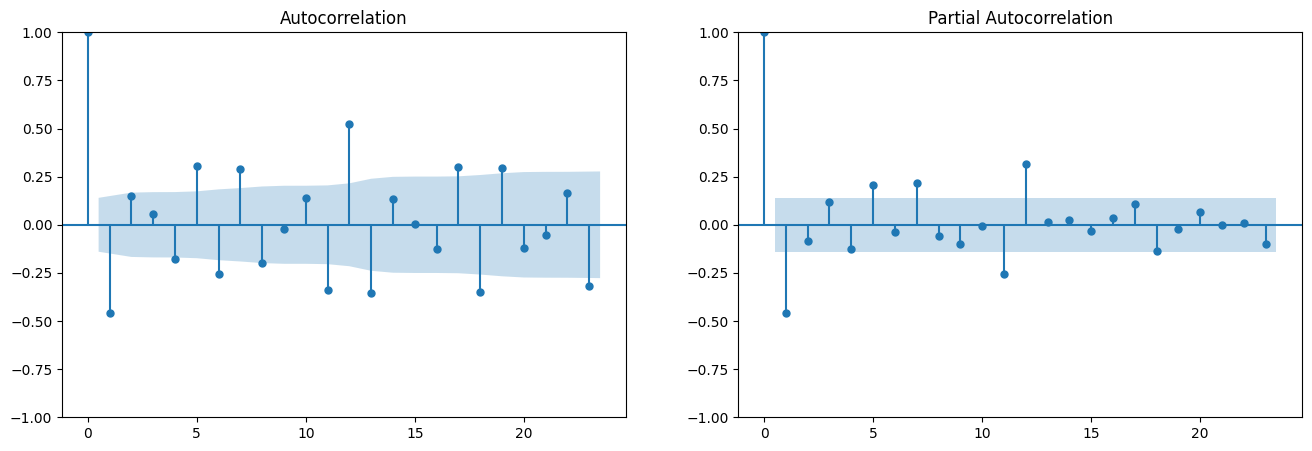

In [ ]:
# Autocorrelation & Partial Autocorrelation Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# Select the specific column for ACF and PACF plots
plot_acf(data_diff['Total Agent Cash in Cash Out (Volume Million)'], ax=axes[0]) # Selecting the relevant column
plot_pacf(data_diff['Total Agent Cash in Cash Out (Volume Million)'], ax=axes[1]) # Selecting the relevant column
plt.show()

In [ ]:
# Splitting Data
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [ ]:
# SARIMA Model Training
# Select only the relevant numeric column for training
train_numeric = train[['Total Agent Cash in Cash Out (Volume Million)']]  # Select the target column

# Now use this numeric data for model training
model = SARIMAX(train_numeric, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                             SARIMAX Results                                             
Dep. Variable:     Total Agent Cash in Cash Out (Volume Million)   No. Observations:                  158
Model:                            SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -424.242
Date:                                           Tue, 01 Apr 2025   AIC                            858.485
Time:                                                   13:41:03   BIC                            873.368
Sample:                                                        0   HQIC                           864.532
                                                           - 158                                         
Covariance Type:                                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

In [ ]:
# Model Evaluation
# Select only the relevant column from test data for comparison
test_numeric = test[['Total Agent Cash in Cash Out (Volume Million)']]  # Select the target column

predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
mae = mean_absolute_error(test_numeric, predictions)  # Use test_numeric instead of test
mse = mean_squared_error(test_numeric, predictions)  # Use test_numeric instead of test
rmse = np.sqrt(mse)
print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')

MAE: 10.541607335056943, MSE: 142.91875802264158, RMSE: 11.954863362775903


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


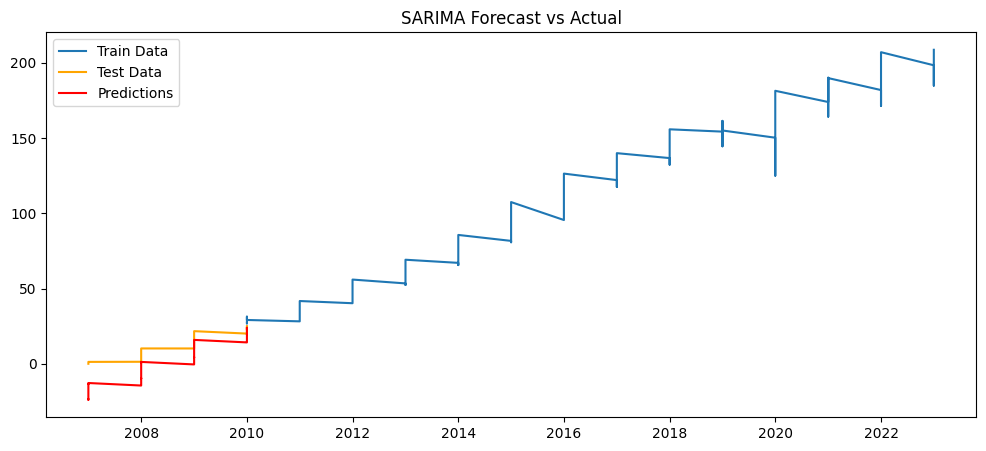

In [ ]:
# Plotting Predictions
plt.figure(figsize=(12, 5))
# Selecting the target column for plotting from train, test, and predictions
plt.plot(train.index, train['Total Agent Cash in Cash Out (Volume Million)'], label='Train Data')
plt.plot(test.index, test['Total Agent Cash in Cash Out (Volume Million)'], label='Test Data', color='orange')
plt.plot(test.index, predictions, label='Predictions', color='red')
plt.legend()
plt.title('SARIMA Forecast vs Actual')
plt.show()

In [ ]:
# Forecasting Future Values
future_steps = 12
forecast = model_fit.forecast(steps=future_steps)
print(f'Forecasted Values:\n{forecast}')

Forecasted Values:
158    23.851072
159    23.274335
160    19.357597
161    19.497122
162    14.948701
163    14.217147
164    15.879180
165    14.931256
166    14.884089
167    12.231939
168    11.416663
169    10.636432
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# User Input & Prediction
steps = int(input("Enter the number of future steps to predict: "))
user_forecast = model_fit.forecast(steps=steps)
print(f'Predicted values for next {steps} steps:\n{user_forecast}')

Enter the number of future steps to predict: 35
Predicted values for next 35 steps:
158    23.851072
159    23.274335
160    19.357597
161    19.497122
162    14.948701
163    14.217147
164    15.879180
165    14.931256
166    14.884089
167    12.231939
168    11.416663
169    10.636432
170     8.015491
171     7.720878
172     4.153341
173     4.496876
174     0.145751
175    -0.411760
176     1.257080
177     0.632105
178     0.823955
179    -1.671379
180    -2.670199
181    -3.300163
182    -5.945599
183    -6.249806
184    -9.840151
185    -9.504715
186   -13.866240
187   -14.433783
188   -12.755763
189   -13.413697
190   -13.245545
191   -15.755281
192   -16.726027
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# User Input & Prediction
steps = int(input("Enter the number of future steps to predict: "))
user_forecast = model_fit.forecast(steps=steps)
print(f'Predicted values for next {steps} steps:\n{user_forecast}')

Enter the number of future steps to predict: 35
Predicted values for next 35 steps:
158    23.851072
159    23.274335
160    19.357597
161    19.497122
162    14.948701
163    14.217147
164    15.879180
165    14.931256
166    14.884089
167    12.231939
168    11.416663
169    10.636432
170     8.015491
171     7.720878
172     4.153341
173     4.496876
174     0.145751
175    -0.411760
176     1.257080
177     0.632105
178     0.823955
179    -1.671379
180    -2.670199
181    -3.300163
182    -5.945599
183    -6.249806
184    -9.840151
185    -9.504715
186   -13.866240
187   -14.433783
188   -12.755763
189   -13.413697
190   -13.245545
191   -15.755281
192   -16.726027
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
